<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/VGG19_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
# Standard library imports
import os
import ast

# Third-party general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Additional Keras imports
from keras.utils import to_categorical

# Imports from Google Colab
from google.colab import files

# Access Dataset via Kaggle API


In [2]:
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
100% 1.62G/1.62G [00:13<00:00, 170MB/s]
100% 1.62G/1.62G [00:13<00:00, 126MB/s]


# Loading the Dataset

In [2]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Splitting the Data

In [3]:
# Splitting the dataset into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Data Distribution
- Class Distribution of Train, Test and Validation Data - all three sets portray the class imbalance represented by Myopia, Hypertension, AMD, Cataract and Glaucoma. 

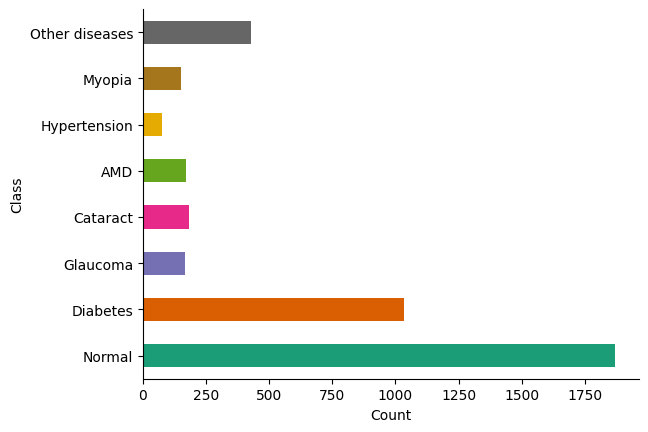

In [4]:
# @title Distribution of Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

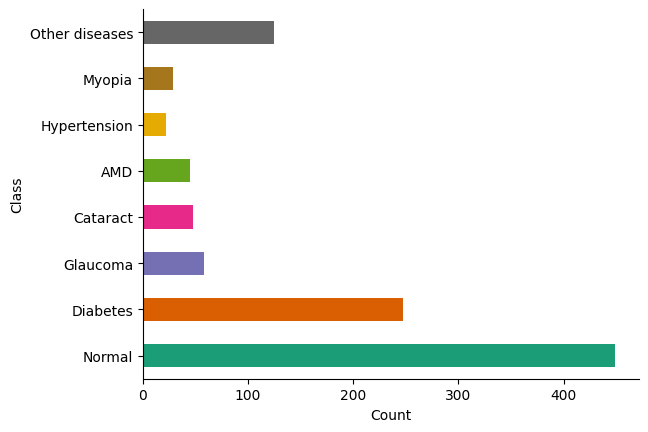

In [5]:
# @title Distribution of Validation Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
val_df['class_name'] = val_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


class_counts = val_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

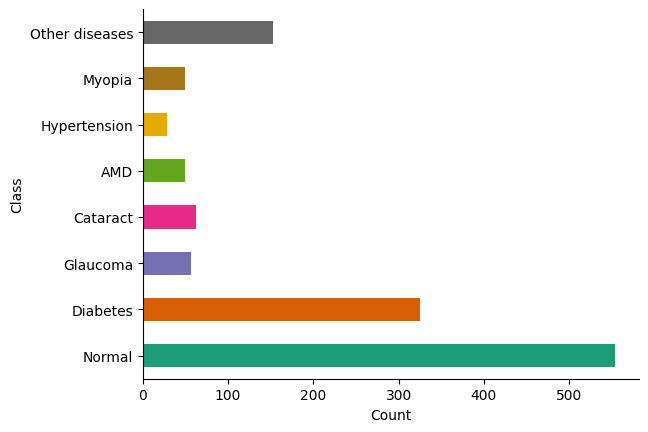

In [6]:
# @title Distribution of Test Data
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])

class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# Data Preparation

## Apply random sampling
- A combination of oversampling and undersampling applied to the data.
- The idea is to balance the data by oversampling the minority class and then undersampling the majority class.


In [7]:

class_distribution = train_df['target'].value_counts()


# Set minimum and maximum thresholds
min_threshold = int(class_distribution.max() * 0.5)  # minimum is half of the largest class size
max_threshold = int(class_distribution.max() * 0.8)  # maximum is 80% of the largest class size

# Determine target samples per class based on conditions
n_samples_per_class = {
    label: max(min_threshold, min(len(df_class), max_threshold)) for label, df_class in train_df.groupby('target')
}

print("Number of samples per class to resample to:", n_samples_per_class)

df_resampled = pd.DataFrame(columns=train_df.columns)

# Upsample or downsample each class according to the specified logic
for class_label, target_count in n_samples_per_class.items():
    df_class = train_df[train_df['target'] == class_label]

    if not df_class.empty:
        # Resample each class to the target count
        df_class_resampled = resample(df_class,
                                      replace=len(df_class) < target_count,  # Sample with replacement if upsampling
                                      n_samples=target_count,  # Target count determined by the logic above
                                      random_state=123)  # For reproducibility
        df_resampled = pd.concat([df_resampled, df_class_resampled])
    else:
        print(f"No samples for class {class_label}. Check your data.")

df_resampled = df_resampled.sample(frac=1, random_state=123).reset_index(drop=True)


Number of samples per class to resample to: {'[0, 0, 0, 0, 0, 0, 0, 1]': 935, '[0, 0, 0, 0, 0, 0, 1, 0]': 935, '[0, 0, 0, 0, 0, 1, 0, 0]': 935, '[0, 0, 0, 0, 1, 0, 0, 0]': 935, '[0, 0, 0, 1, 0, 0, 0, 0]': 935, '[0, 0, 1, 0, 0, 0, 0, 0]': 935, '[0, 1, 0, 0, 0, 0, 0, 0]': 1036, '[1, 0, 0, 0, 0, 0, 0, 0]': 1496}


**Class distribution before sampling**

In [8]:
class_distribution = train_df['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1870
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 0, 1]     430
[0, 0, 0, 1, 0, 0, 0, 0]     183
[0, 0, 0, 0, 1, 0, 0, 0]     171
[0, 0, 1, 0, 0, 0, 0, 0]     169
[0, 0, 0, 0, 0, 0, 1, 0]     153
[0, 0, 0, 0, 0, 1, 0, 0]      78
Name: count, dtype: int64


**Class Distribution after sampling**

In [9]:
class_distribution = df_resampled['target'].value_counts()
print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1496
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 1, 0]     935
[0, 0, 0, 0, 0, 1, 0, 0]     935
[0, 0, 0, 0, 1, 0, 0, 0]     935
[0, 0, 0, 0, 0, 0, 0, 1]     935
[0, 0, 1, 0, 0, 0, 0, 0]     935
[0, 0, 0, 1, 0, 0, 0, 0]     935
Name: count, dtype: int64


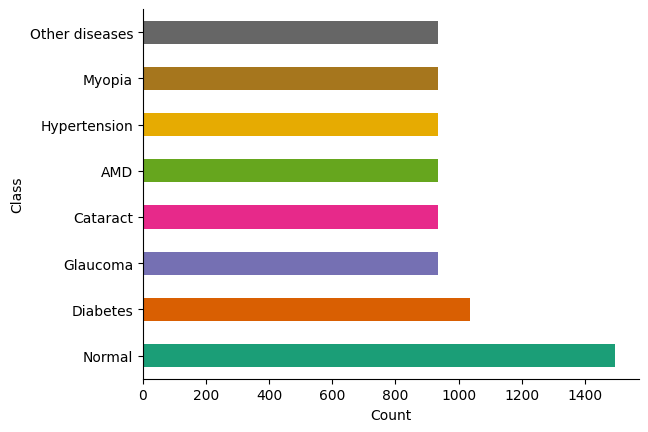

In [10]:
# @title Distribution of Sampled Training Data

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_resampled['class_name'] = df_resampled['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_resampled['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

##Image Preprocessing

In [11]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)  # Preprocessing the image to be compatible with pretrained model
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2) 
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

Preparing Train, Test and Validation Datasets

In [14]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]  # Keep labels corresponding to the valid filenames

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset


In [17]:
train_ds = load_and_prepare_dataset(df_resampled, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=True, batch_size=32)
test_ds = load_and_prepare_dataset(test_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=32)
val_ds = load_and_prepare_dataset(val_df, 'ODIR-5K/ODIR-5K/Training Images/', shuffle=False, batch_size=32)


Size of Datasets

In [18]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  509
size of validation dataset:  64
size of testing dataset:  80


# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


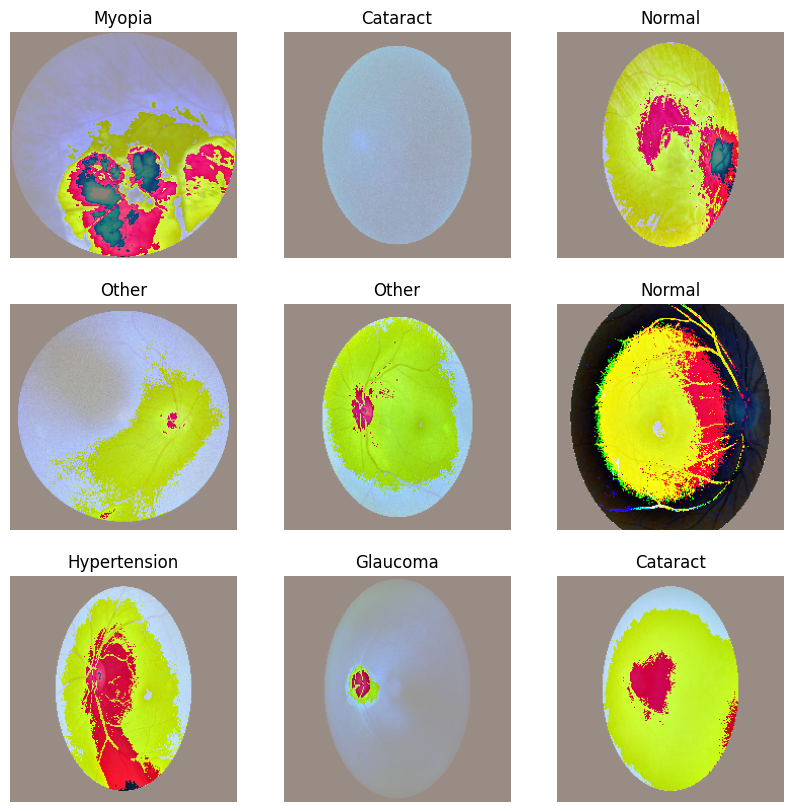

In [19]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


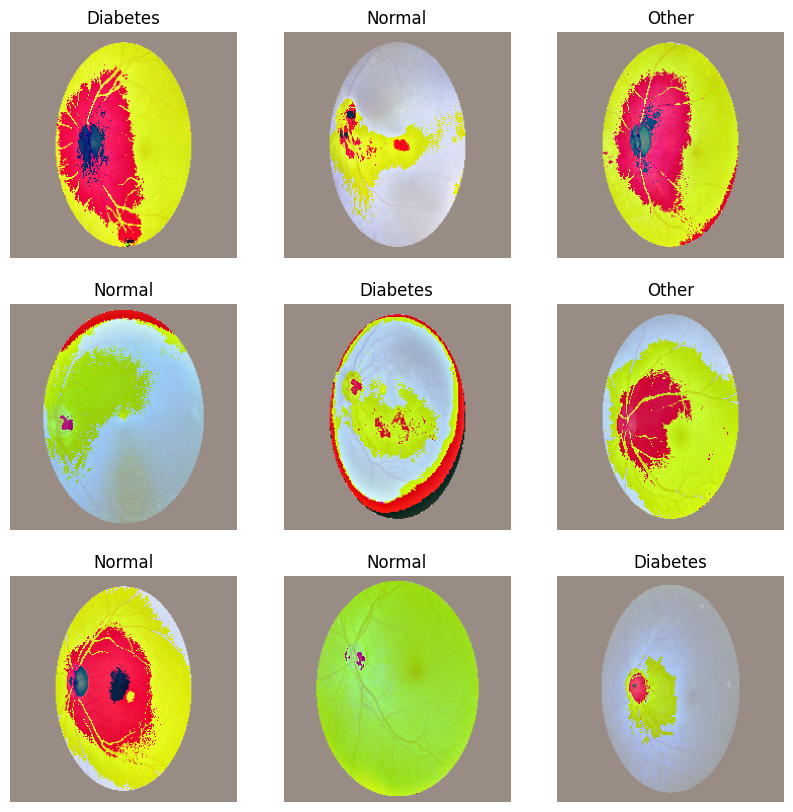

In [20]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

In [22]:
# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [23]:
pretrained_model = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 20291144 (77.40 MB)
Trainable params: 266760 (1.02 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


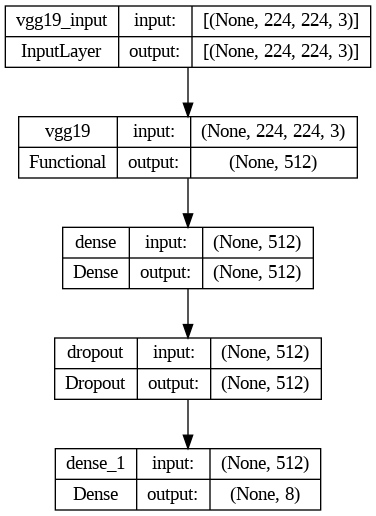

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
epochs = 80
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/80
509/509 [==============================] - ETA: 0s - loss: 2.7161 - accuracy: 0.3701
Epoch 1: val_loss improved from inf to 2.09585, saving model to best_model
509/509 [==============================] - 110s 142ms/step - loss: 2.7161 - accuracy: 0.3701 - val_loss: 2.0959 - val_accuracy: 0.4032 - lr: 1.0000e-04
Epoch 2/80
509/509 [==============================] - ETA: 0s - loss: 1.8437 - accuracy: 0.4963
Epoch 2: val_loss improved from 2.09585 to 1.89777, saving model to best_model
509/509 [==============================] - 95s 126ms/step - loss: 1.8437 - accuracy: 0.4963 - val_loss: 1.8978 - val_accuracy: 0.4428 - lr: 1.0000e-04
Epoch 3/80
509/509 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.5680
Epoch 3: val_loss improved from 1.89777 to 1.89523, saving model to best_model
509/509 [==============================] - 96s 129ms/step - loss: 1.5866 - accuracy: 0.5680 - val_loss: 1.8952 - val_accuracy: 0.4316 - lr: 1.0000e-04
Epoch 4/80
509/509 [=====

# Evaluating Model
- Model Accuracy
- Model Loss


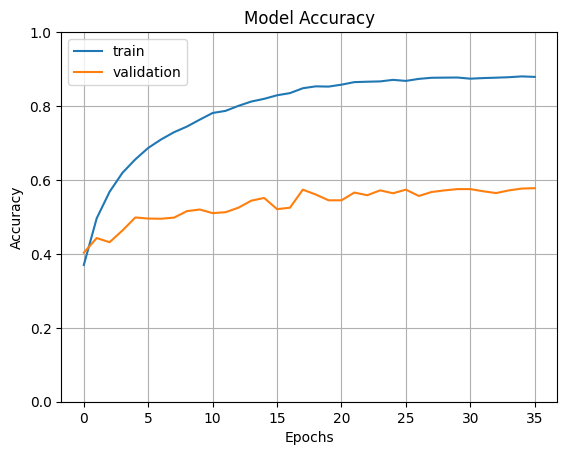

In [29]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

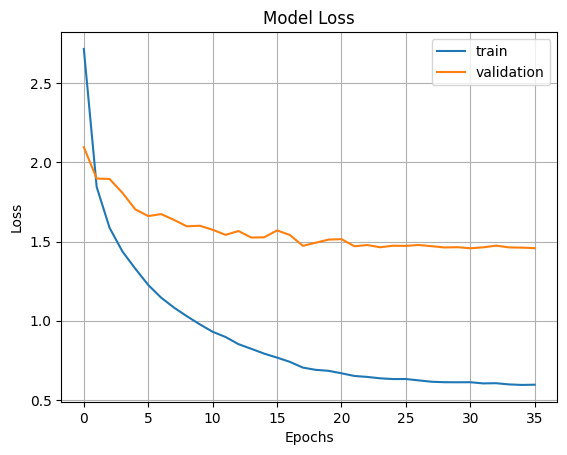

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Finetuning

In [31]:
# dictionary to store training history
full_history = {}

# Function to unfreeze layers gradually 1-4
def unfreeze_model(model, pretrained_model, n_layers):
    # Unfreeze the top `n_layers` of the pretrained model
    for layer in pretrained_model.layers[-n_layers:]:
        layer.trainable = True

    # Recompile the model every time change is made to layer's `trainable` status
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Gradually unfreeze the layers and save history
for i in range(1, 5):  #  unfreeze the top 4 layers one by one
    print(f"Unfreezing top {i} layers and retraining.")
    unfreeze_model(model, pretrained_model, i)

    history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)

    # Save the history in the full_history dictionary
    full_history[f'phase_{i}'] = history.history

    # Save the model at each phase
    model.save(f'model_after_unfreezing_{i}_layers.h5')

Unfreezing top 1 layers and retraining.
Epoch 1/10
509/509 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.8801
Epoch 1: val_loss did not improve from 1.45779
509/509 [==============================] - 97s 124ms/step - loss: 0.5993 - accuracy: 0.8801 - val_loss: 1.4710 - val_accuracy: 0.5630 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.8819
Epoch 2: val_loss did not improve from 1.45779
509/509 [==============================] - 94s 126ms/step - loss: 0.5973 - accuracy: 0.8819 - val_loss: 1.4690 - val_accuracy: 0.5714 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.8856
Epoch 3: val_loss did not improve from 1.45779
509/509 [==============================] - 95s 126ms/step - loss: 0.5906 - accuracy: 0.8856 - val_loss: 1.4674 - val_accuracy: 0.5655 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.5930 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.8784
Epoch 1: val_loss improved from 1.45779 to 1.45574, saving model to best_model
509/509 [==============================] - 98s 131ms/step - loss: 0.5921 - accuracy: 0.8784 - val_loss: 1.4557 - val_accuracy: 0.5792 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.8845
Epoch 2: val_loss did not improve from 1.45574
509/509 [==============================] - 94s 126ms/step - loss: 0.5895 - accuracy: 0.8845 - val_loss: 1.4626 - val_accuracy: 0.5782 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.8808
Epoch 3: val_loss did not improve from 1.45574
509/509 [==============================] - 95s 126ms/step - loss: 0.5876 - accuracy: 0.8808 - val_loss: 1.4588 - val_accuracy: 0.5743 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.8838
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


509/509 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.8796
Epoch 1: val_loss did not improve from 1.45574
509/509 [==============================] - 86s 105ms/step - loss: 0.5834 - accuracy: 0.8796 - val_loss: 1.5284 - val_accuracy: 0.5621 - lr: 1.0000e-05
Epoch 2/10
509/509 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.8849
Epoch 2: val_loss did not improve from 1.45574
509/509 [==============================] - 84s 104ms/step - loss: 0.5554 - accuracy: 0.8849 - val_loss: 1.5276 - val_accuracy: 0.5601 - lr: 1.0000e-05
Epoch 3/10
509/509 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.8954
Epoch 3: val_loss did not improve from 1.45574
509/509 [==============================] - 83s 104ms/step - loss: 0.5321 - accuracy: 0.8954 - val_loss: 1.5248 - val_accuracy: 0.5831 - lr: 1.0000e-05
Epoch 4/10
509/509 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.9009
Epoch 4: val_loss did not improve

# Evaluating Model
- Model Accuracy
- Model Loss


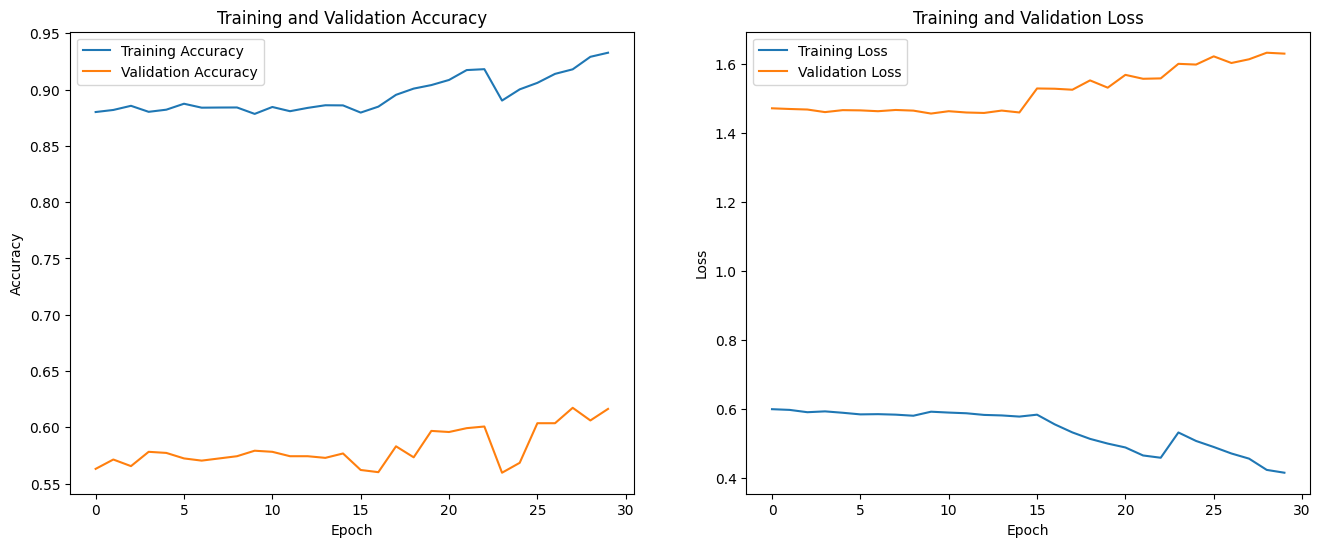

In [32]:
# Function to plot accuracy and loss
def plot_history(full_history):
    # Initialize lists for the plot
    acc, val_acc, loss, val_loss = [], [], [], []

    # Aggregate the history data
    for phase, history in full_history.items():
        acc += history['accuracy']
        val_acc += history['val_accuracy']
        loss += history['loss']
        val_loss += history['val_loss']

    # Plotting
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(full_history)


# Making Predictions


In [33]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

80/80 [==============================] - 9s 110ms/step - loss: 1.6107 - accuracy: 0.5520
Test accuracy: 55.2%


80/80 [==============================] - 9s 110ms/step - loss: 1.6107 - accuracy: 0.5520
Evaluation results: [1.6106973886489868, 0.551993727684021]
80/80 [==============================] - 9s 111ms/step


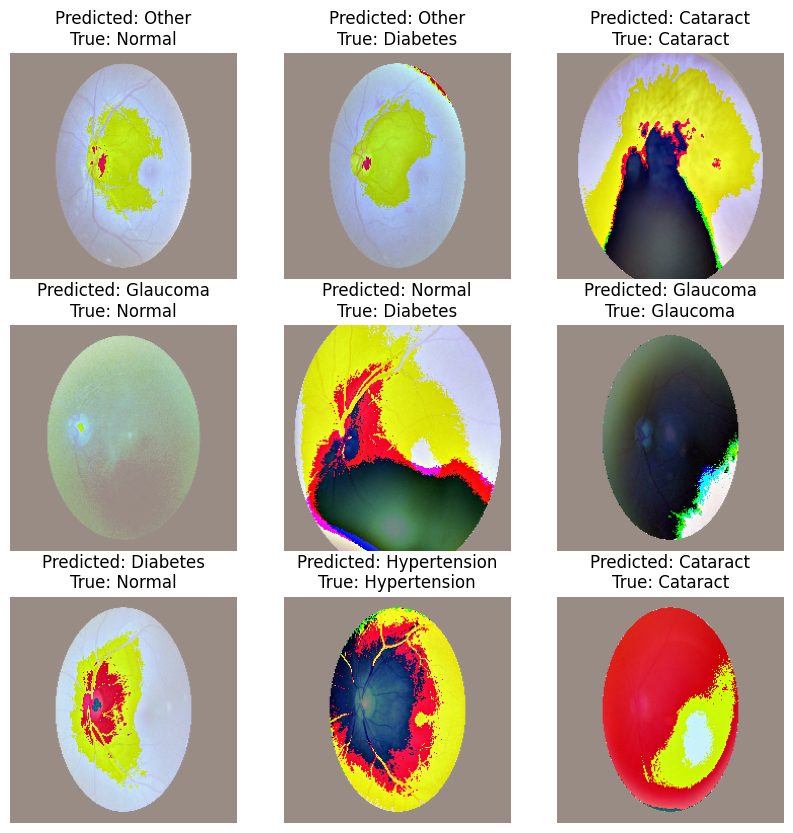

In [34]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

num_images_to_display = 9

# lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation

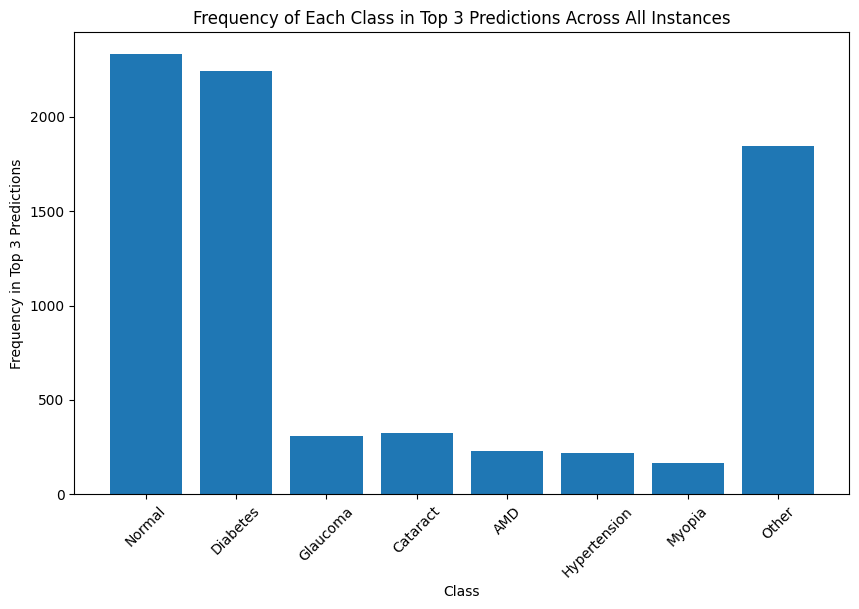

In [35]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [36]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [37]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2558, 8)


In [38]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.67      0.52      0.59      1108
      Diabetes       0.48      0.68      0.57       650
      Glaucoma       0.53      0.61      0.57       114
      Cataract       0.58      0.65      0.61       124
           AMD       0.64      0.64      0.64       100
  Hypertension       0.53      0.52      0.52        56
        Myopia       0.73      0.74      0.73       100
Other diseases       0.28      0.23      0.26       306

      accuracy                           0.55      2558
     macro avg       0.56      0.57      0.56      2558
  weighted avg       0.56      0.55      0.55      2558



Balanced Accuracy Score

In [39]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5745


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [40]:
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8465


Confusion Matrix

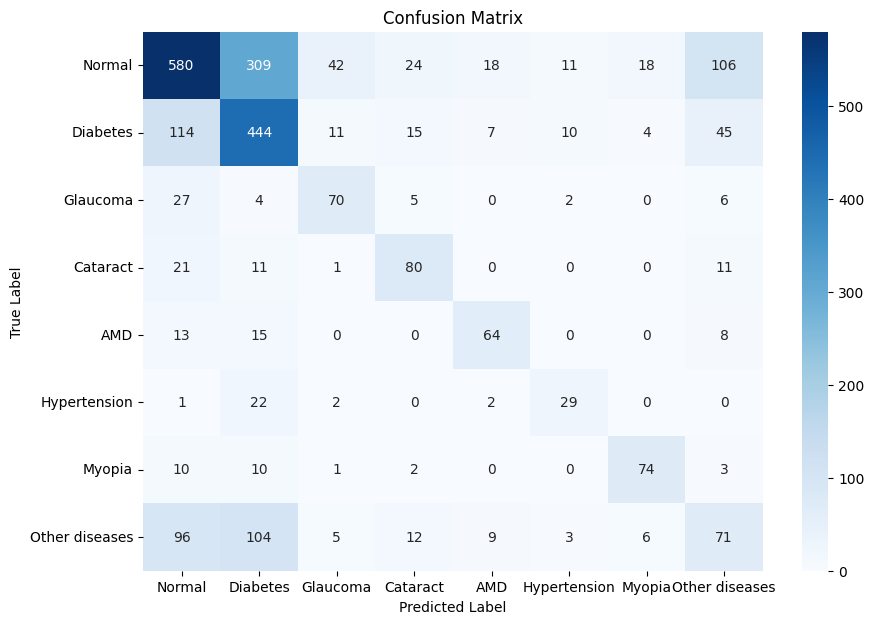

In [41]:
# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Normalised Confusion Matrix

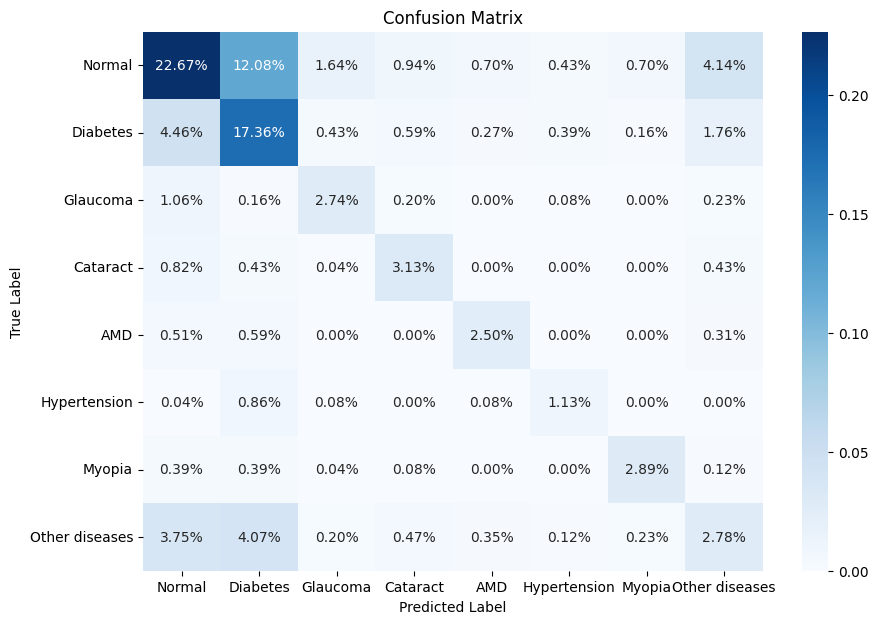

In [42]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()